# LSTM Modellierung – Human Activity Recognition
In diesem Notebook trainieren wir ein LSTM-Modell zur Klassifikation von Aktivitäten anhand von Smartphone-Sensordaten.
Schritte:
- Laden der vorbereiteten Daten
- Aufbau des LSTM-Modells
- Training
- Evaluation

In [25]:
# Bibliotheken
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.figure_factory as ff



In [2]:
# Daten laden (anpassen falls nötig)
data_path = '../data/'

# CSVs einlesen
train_df = pd.read_csv(data_path + "train.csv")
test_df = pd.read_csv(data_path + "test.csv")

In [3]:
# Zielvariable definieren und encoden
target_col = 'Activity'
le = LabelEncoder()
train_df[target_col] = le.fit_transform(train_df[target_col])
test_df[target_col] = le.transform(test_df[target_col])  # falls gleiche Labels

In [4]:
# Features und Ziel trennen
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col].values

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col].values

In [5]:
# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Reshape für LSTM (Samples, TimeSteps=1, Features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [7]:
# Umwandlung in Tensoren
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [15]:
# Label-Encoding
le = LabelEncoder()
train_df["Activity"] = le.fit_transform(train_df["Activity"])
test_df["Activity"] = le.transform(test_df["Activity"])

# Features und Zielvariable trennen
X_train = train_df.drop(columns=["Activity"]).values
y_train = train_df["Activity"].values
X_val = test_df.drop(columns=["Activity"]).values
y_val = test_df["Activity"].values

# Skalieren
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape für LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

# In Torch-Tensoren umwandeln
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)


In [18]:
# ⚙️ Parameter
hidden_size = 128
num_layers = 2
dropout = 0.3
activation = "relu"
batch_size = 64
lr = 1e-3
weight_decay = 1e-5
epochs = 10
patience = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# Modellklasse
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, dropout=0.0, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "tanh":
            self.activation = nn.Tanh()
        else:
            raise ValueError("Unsupported activation function")


    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # nur letzter Zeitschritt
        out = self.activation(out)
        out = self.fc(out)
        return out


# Initialisierung
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train.shape[2]
num_classes = len(torch.unique(torch.cat([y_train, y_val])))
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes,
                  num_layers=num_layers, dropout=dropout, activation=activation).to(device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

train_losses, val_losses = [], []
best_val_acc = 0
best_model_state = model.state_dict()
counter = 0

train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

for epoch in range(epochs):
    # Training
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        all_preds.extend(preds.argmax(dim=1).cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

    train_loss = epoch_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_f1s.append(train_f1)

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds, yb).item()
            val_preds.extend(preds.argmax(dim=1).cpu().numpy())
            val_labels.extend(yb.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_rec = recall_score(val_labels, val_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='weighted', zero_division=0)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Bestes Modell laden
model.load_state_dict(best_model_state)


Epoch 1: Train Loss=0.8380, Val Loss=0.3395, Val Acc=0.9213
Epoch 2: Train Loss=0.1870, Val Loss=0.2191, Val Acc=0.9267
Epoch 3: Train Loss=0.0922, Val Loss=0.2144, Val Acc=0.9335
Epoch 4: Train Loss=0.0629, Val Loss=0.2113, Val Acc=0.9301
Epoch 5: Train Loss=0.0540, Val Loss=0.2308, Val Acc=0.9342
Epoch 6: Train Loss=0.0463, Val Loss=0.2182, Val Acc=0.9365
Epoch 7: Train Loss=0.0401, Val Loss=0.2180, Val Acc=0.9410
Epoch 8: Train Loss=0.0304, Val Loss=0.2202, Val Acc=0.9427
Epoch 9: Train Loss=0.0257, Val Loss=0.2151, Val Acc=0.9399
Epoch 10: Train Loss=0.0281, Val Loss=0.2125, Val Acc=0.9474


<All keys matched successfully>

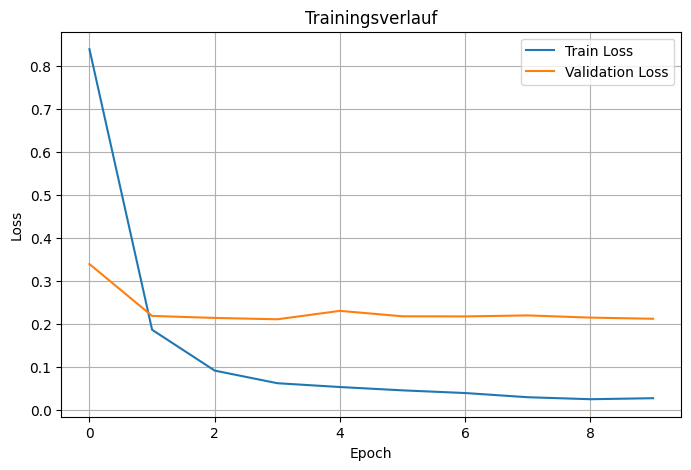

In [20]:
# 📉 Trainings- und Validierungs-Loss visualisieren
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trainingsverlauf")
plt.legend()
plt.grid(True)
plt.show()


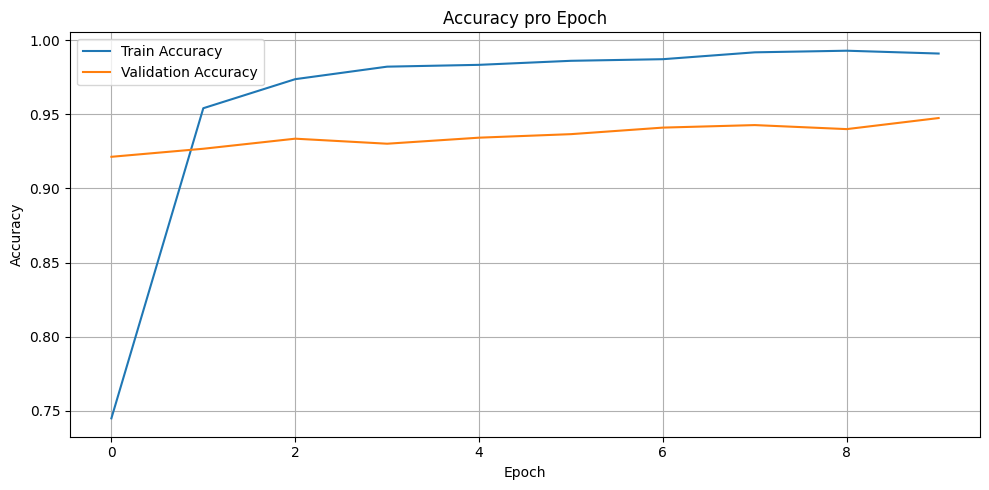

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy pro Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


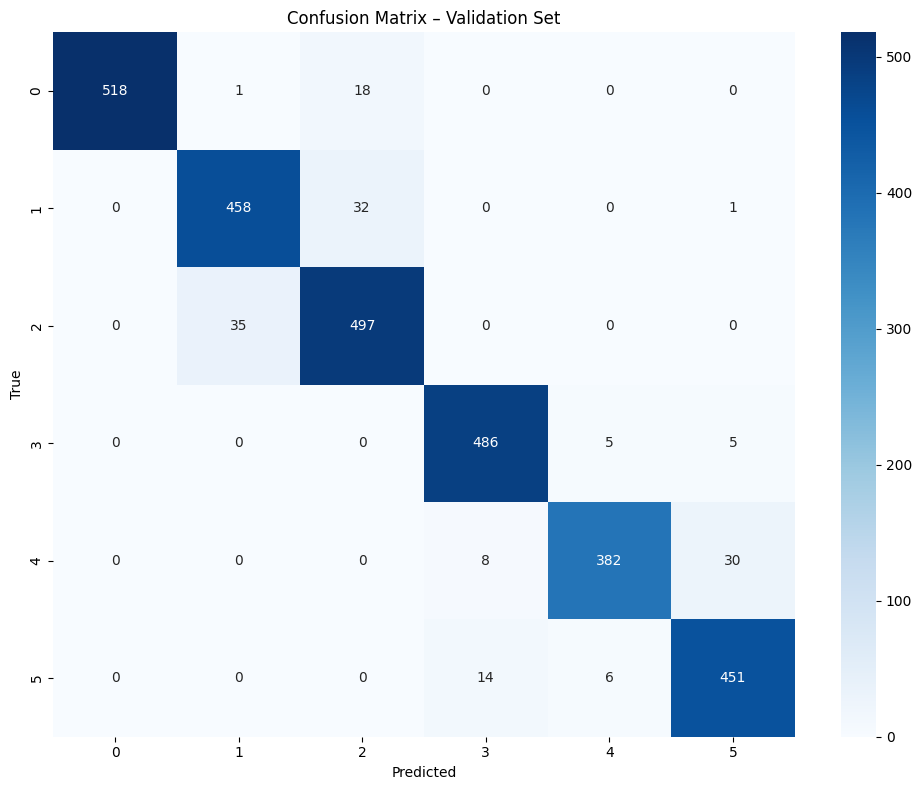

In [23]:
# Modell auf Validierungsdaten anwenden
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        preds = model(xb)
        preds = preds.argmax(dim=1).cpu().numpy()
        labels = yb.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

# Confusion Matrix berechnen
cm = confusion_matrix(all_labels, all_preds)
class_names = le.classes_  # original Klassenbezeichnungen

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Validation Set")
plt.tight_layout()
plt.show()


In [30]:
class_names = le.classes_.tolist()

# Interaktive Darstellung
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale="Blues",
    showscale=True,
    reversescale=False
)

fig.update_layout(
    title="Interaktive Confusion Matrix (Validation Set)",
    xaxis_title="Predicted Label",
    yaxis_title="True Label"
)
fig.show()


In [28]:
# Klassifikationsbericht
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report[["precision", "recall", "f1-score", "support"]]
df_report.round(3)


,precision,recall,f1-score,support
0,1.000,0.965,0.982,537.000
1,0.927,0.933,0.930,491.000
2,0.909,0.934,0.921,532.000
3,0.957,0.980,0.968,496.000
4,0.972,0.910,0.940,420.000
5,0.926,0.958,0.942,471.000
accuracy,0.947,0.947,0.947,0.947
macro avg,0.948,0.946,0.947,2947.000
weighted avg,0.948,0.947,0.948,2947.000
